# Coding exercise for Wang Lab
### Implementation of nnU-net for the segmentation of pancreas and pancreatic lesions on CT scan, with classication of the pancreatic lesions
### 3D version
### by Leo Chen
### August/September 2024

In [1]:
### IMPORTS
import os
import glob
#import util

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.init as init

from collections import defaultdict
from collections import Counter

from datetime import datetime

import SimpleITK as sitk
#import nibabel as nib

In [2]:
### GLOBAL VARIABLES

# using GPU?
gpu = False

# first time running? need to generate csv and npy files
firstrun = True

# use resampled (1x1x3 mm voxel size) or original data?
useResampledData = True

# directories where the files are
traindir = '/kaggle/input/pancreas/train/'
valdir = '/kaggle/input/pancreas/validation/'
testdir = '/kaggle/input/pancreas/test'

numpydir = '/kaggle/working/numpy'

modeldir = '/kaggle/working/models'

csvpath = '/kaggle/working/trainval_metadata.csv'   # csv with the image dimensions, image and mask file paths

resampleddir = '/kaggle/working/resampled'

if os.path.exists(modeldir) == False:
    os.makedirs(modeldir)


model_depth = 5

# patch size
patch_width = 48
patch_height = 48
patch_depth = 48

# CT windowing
window_width = 400
window_center = 50

# Functions for image processing

In [3]:
### FUNCTIONS FOR IMAGE AUGMENTATION

def rotateImage(original, anglex, angley, anglez, interpolate='linear'):
    """ Returns the 'rotated' 3d image about the physical center that is resampled based on the 'original' image
    1. original - original image 
    2. angle x is roll / twisting the body like a rolling pin, turning in dance
    3. angle y is yaw / rotating the body like a propeller blade, like break dancing
    4. angle z - pitch / tilt along the superior/inferior axis (i.e trendelenburg)
    
    """

    if interpolate == 'linear':
        interpolator = sitk.sitkLinear
    elif interpolate == 'NN':
        interpolator = sitk.sitkNearestNeighbor

    radx = anglex * math.pi / 180
    rady = angley * math.pi / 180
    radz = anglez * math.pi / 180

    origin = np.array(original.GetOrigin())
    pixelcenter = np.array(sitk.GetSize(original)) / 2.
    physicalcenter = sitk.TransformContinuousIndexToPhysicalPoint(pixelcenter)

    transform = sitk.Euler3DTransform()
    transform.SetCenter(physicalcenter)
    transform.SetRotation(radz, rady, radx)    # note the order is z, y, x

    unitvecs = np.transpose(np.reshape(original.GetDirection(), (-1, 3)))
    #print(unitvecs)
    matrix = np.reshape(transform.GetMatrix(), (-1, 3))
    inverse = np.linalg.inv(matrix)


    # the transform matrix is actually mapping backwards: post to pre
    # therefore the forward transformation is the inverse matrix
    transformedunitvecs = inverse @ unitvecs   # new i, j, k are columns
    #print(transformedunitvecs)
    newdirection = transformedunitvecs.flatten('F')    # flatten by column

    print(newdirection)
    neworigin = (matrix @ (origin - physicalcenter)) + physicalcenter

    rotatedImage = sitk.Resample(original, original, transform, interpolator)
    rotatedImage.SetDirection(newdirection)
    rotatedImage.SetOrigin(neworigin)

    return rotatedImage

def flipImage(original):
    """Flips an SimpleITK over left/right axis"""
    flipped = sitk.Flip(original, [True, False, False])
    return flipped

def flipslice(original):
    """Flips a numpy slice (2d image) """
    # flips 2D slice (reverses x indices)
    flipped = np.flipud(original)  #np.fliplr(original)
    return flipped

def bbox_3D(img):
    """Finds the bounding box around a 3D image (numpy)
    returns rmin, rmax, cmin, cmax, zmin, zmax (r = row, c = column)"""
    try:    
        z = np.any(img, axis=(1, 2))    #z
        c = np.any(img, axis=(0, 1))    #x , (c = column)
        r = np.any(img, axis=(0, 2))    #y , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
        zmin, zmax = np.where(z)[0][[0, -1]]

        #x min max, y min max, z min max
        return [rmin, rmax, cmin, cmax, zmin, zmax]
    except:
        return -1, -1, -1, -1, -1, -1


def bbox_2D(img):
    """Finds the bounding box around a 2D image (numpy)
    returns rmin, rmax, cmin, cmax (r = row, c = column)
    If no elements exist, then returns (-1, -1, -1, -1)"""
    
    try:
        c = np.any(img, axis=0)    #y , (c = column)
        r = np.any(img, axis=1)    #x , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
    
        return rmin, rmax, cmin, cmax
    except:
        return -1, -1, -1, -1


def cropImage(image, threshold, xshift, yshift):
    """Crops SimpleITK image to remove pixels below a threshold (e.g. black space)
    Can also shift by *xshift and *yshift (random shifts in pixels) for augmentation"""
    # load image
    npy = sitk.GetArrayFromImage(image)

    # GET METADATA
    direction = image.GetDirection()
    spacing = image.GetSpacing()

    # CALCULATE BOUNDING BOX OF BODY (removes black space)
    mask = npy > threshold
    [xmin, xmax, ymin, ymax, zmin, zmax] = bbox_3D(mask)

    # check to make sure shifts do not extend outside boundaries of image
    if xmin + xshift < 0 or xmax + xshift > npy.shape[2]:
        xshift = 0

    if ymin + yshift < 0 or ymax + yshift > npy.shape[1]:
        yshift = 0

    # CROP IMAGE
    newnpy = npy[zmin:zmax, (ymin+yshift):(ymax+yshift), (xmin+xshift):(xmax+xshift)]

    newimage = sitk.GetImageFromArray(newnpy)
    topleft = [int(xmin+xshift), int(ymin+yshift), zmin]
    neworigin = image.TransformIndexToPhysicalPoint(topleft)

    newimage.SetOrigin(neworigin)
    newimage.SetDirection(direction)
    newimage.SetSpacing(spacing)

    return newimage


def squareImage(image):
    """Makes an SimpleITK image square by padding with zeros
    (square meaning width = height)"""
    [numcols, numrows, numslices] = image.GetSize()
    npy = sitk.GetArrayFromImage(image)

    if numcols < numrows:    #pad columns
        numzerostopad = numrows - numcols
        leftpad = int(numzerostopad / 2)
        rightpad = numzerostopad - leftpad

        newnpy = np.concatenate((np.zeros([numslices, numrows, leftpad]), npy, np.zeros([numslices, numrows, rightpad])), axis=2)

        topleft = [-leftpad, 0, 0]
        neworigin = image.TransformIndexToPhysicalPoint(topleft)

    elif numrows <= numcols:  #pad rows
        numzerostopad = numcols - numrows
        toppad = int(numzerostopad / 2)
        botpad = numzerostopad - toppad

        newnpy = np.concatenate((np.zeros([numslices, toppad, numcols]), npy, np.zeros([numslices, botpad, numcols])), axis=1)

        topleft = [0, -toppad, 0]
        neworigin = image.TransformIndexToPhysicalPoint(topleft)

    paddedimg = sitk.GetImageFromArray(newnpy)
    paddedimg.SetOrigin(neworigin)
    paddedimg.SetDirection(image.GetDirection())
    paddedimg.SetSpacing(image.GetSpacing())

    return paddedimg

def resampleImage(image, finalsize, interpolation='linear'):
    """Resamples SimpleITK image to finalsize x finalsize (width and height in pixels)
    Preserves the original physical size of the image and number of slices
    Changes the resolution so that the new image has numslices x *finalsize x *finalsize dimensions"""
    
    size = image.GetSize()
    numslices = size[2]
    squaresize = size[1]

    # RESAMPLE TO finalsize x finalsize
    finalnpy = np.zeros([numslices, finalsize, finalsize])
    reference = sitk.GetImageFromArray(finalnpy)
    reference.SetOrigin(image.GetOrigin())
    reference.SetDirection(image.GetDirection())

    spacing = image.GetSpacing()
    newspacing = np.zeros(3)
    newspacing[0:2] = (squaresize - 1) * np.array(spacing[0:2]) / (finalsize - 1)
    newspacing[2] = spacing[2]
    reference.SetSpacing(newspacing)


    # MAKING RESAMPLING FILTER
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolation == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolation == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    # RESAMPLE TO finalsize x finalsize x n
    resampledimg = resample.Execute(image)

    return resampledimg


def projectImage(reference, moving, interpolate = 'linear'):
    """Projects an SimpleITK image (*moving onto *reference)
    interpolate* = linear or NN (nearest neighbor)"""
    
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolate == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolate == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    resampledimg = resample.Execute(moving)

    return resampledimg


def resampleImageToVoxelSize(image, voxelx, voxely, voxelz, interpolation='linear'):
    """Resamples SimpleITK *image* to spacing *[voxelx, voxely, voxelz] in mm
    Preserves the original physical size of the image
    *voxelz is slice thickness (usually)
    *voxelx and *voxely are voxel width and height, respectively
    """
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    new_spacing = [voxelx, voxely, voxelz]
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    # new dimension will be original size * original spacing / new spacing
    # based on physical distance formula: 
    #    original size (pixel) * original spacing (mm / pixel) = new size (pixel) * new spacing (mm / pixel)
    
    if interpolation == 'linear':
        interpolator = sitk.sitkLinear
    elif interpolation == 'NN':
        interpolator = sitk.sitkNearestNeighbor
    
    # creates new image
    new_image = sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())
    
    return new_image


def windowImage(image, window_width, window_center, output_min=0, output_max=255):
    """Normalizes SimpleITK *image* (CT scan) based on window specification
    (example, abdominal soft tissue window is W = 400, C = 50, or -350 to 450)
    Clips values above 0 and 1
    """
    
    window_min = window_center - window_width / 2
    window_max = window_center + window_width / 2
    
    output_min = 0
    output_max = 255
    
    windowed_image = sitk.IntensityWindowing(image, window_min, window_max, output_min, output_max)
    
    return windowed_image
    



## one hot functions

In [4]:
# Perform one hot encoding on segmentation label
def one_hot_encode(label, label_values = [0, 1, 2]):
    """
    Convert a segmentation image label array to one-hot format by replacing each pixel label with an array of n dimension (n labels)
    
    1. label: The 3D array segmentation image label
    2. label_values (in this case, [0, 1, 2])
        
    Returns the one-hot 4d matrix (n x num_row x num_col)
        
    """
    one_hot = []
    
    for number in label_values:
        layer = np.int32(np.equal(label, number))
        one_hot.append(layer)
    
    one_hot = np.stack(one_hot, axis=0)

    return one_hot
    
# Perform reverse one-hot-encoding on segementation labels / preds
def one_hot_decode(one_hot_label):
    """
    Squashes a 4D one hot matrix into a 3D segmentation mask
    """
    label = np.argmax(one_hot_label, axis = 0)
    
    return label


# one-hot encoding of lesions

def one_hot_encode_lesion(label, label_values = [0, 1, 2, 3]):
    """
    Convert a lesion class into one hot format
    
    label: 0, 1, 2, or 3
    
    returns one-hot array
    """
    
    one_hot = np.zeros((len(label_values)))
    one_hot[label] = 1
    
    return one_hot

def one_hot_decode_lesion(one_hot_label):
    """
    Squashes a 3D one hot matrix into a 2D segmentation mask
    """
    label = np.argmax(one_hot_label, axis = 0)
    
    return label

# U-net 3D (segmentation head)

In [5]:
### U-Net model classes and functions

class UNet(nn.Module):
    """3D U-Net Model (nn-Unet without hyperparameter optimization)
    Adapted by Leo Chen from code by Andrew Ng's lab (circa 2018)
    """

    def __init__(self, model_depth=5, num_channels=1, num_classes=1, init_method=None, **kwargs):
        super(UNet, self).__init__()
        self.depth = model_depth
        self.num_channels = num_channels
        self.num_classes = num_classes

        u_channels = 64  # Number of channels at the top of the "U"
        layer_depths = [i for i in range(1, model_depth)]

        self.input_conv = UNetConvBlock(self.num_channels, u_channels)

        self.encoders = nn.ModuleList([UNetEncoder(u_channels * 2**(i - 1), u_channels * 2**i)
                                       for i in layer_depths])

        self.decoders = nn.ModuleList([UNetDecoder(u_channels * 2**i, u_channels * 2**(i - 1))
                                       for i in reversed(layer_depths)])

        self.output_conv = nn.Conv3d(u_channels, self.num_classes, 1)

        
        if init_method is not None:
            self._initialize_weights(init_method)

    def _initialize_weights(self, init_method):
        """Initialize all weights in the network."""
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                if init_method == 'normal':
                    init.normal_(m.weight, 0.0, 0.2)
                elif init_method == 'xavier':
                    init.xavier_normal_(m.weight, 0.2)
                elif init_method == 'kaiming':
                    init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                else:
                    raise NotImplementedError('Invalid initialization method: {}'.format(self.init_method))
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d) or (isinstance(m, nn.GroupNorm) and m.affine):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_conv(x)
        skips = []

        # Encode and save skip connections
        for encoder in self.encoders:
            skips.append(x)
            x = encoder(x)

        # Decode with skip connections
        for decoder in self.decoders:
            x_skip = skips.pop()
            x = decoder(x, x_skip)

        # Generate mask
        x = self.output_conv(x)

        return x

    def args_dict(self):
        """Get a dictionary of args that can be used to reconstruct this architecture.
        To use the returned dict, initialize the model with `LRCN(**model_args)`.
        """
        model_args = {'model_depth': self.depth,
                      'num_channels': self.num_channels,
                      'num_classes': self.num_classes}

        return model_args

    
class UNetConvBlock(nn.Module):
    """2 x (Conv3d, BatchNorm3d, ReLU)"""

    ### may need to play around with kernel_size
#    The parameters kernel_size, stride, padding, dilation can either be:
# a single int – in which case the same value is used for the depth, height and width dimension
#    OR
# a tuple of three ints – in which case, 
# the first int is used for the depth dimension, 
# the second int for the height dimension and 
# the third int for the width dimension


    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bias=True):
        super(UNetConvBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=use_bias)
        self.norm1 = nn.GroupNorm(out_channels // 16, out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=use_bias)
        self.norm2 = nn.GroupNorm(out_channels // 16, out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)

        return x
    
    
class UNetCopyCrop(nn.Module):
    """Layer for cropping then concatenating skip connection in UNet."""
    def __init__(self):
        super(UNetCopyCrop, self).__init__()

    def forward(self, x, x_skip):
        crop_h = (x.size(2) - x_skip.size(2))
        crop_w = (x.size(3) - x_skip.size(3))
        # Round in opposite directions on either side
        x_skip = F.pad(x_skip, (crop_h//2, int(crop_h/2), crop_w//2, int(crop_w/2)))
        x = torch.cat([x_skip, x], dim=1)

        return x

    
class UNetDecoder(nn.Module):
    """Decoder (up-sampling layer) for UNet"""
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()

        self.up = nn.ConvTranspose3d(in_channels, out_channels, 2, stride=2)
        self.copy_crop = UNetCopyCrop()
        self.conv = UNetConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, x_skip):
        x = self.up(x)
        x = torch.cat([x_skip, x], dim=1)  # self.copy_crop(x, x_skip)
        x = self.conv(x)

        return x
    

class UNetEncoder(nn.Module):
    """Encoder (down-sampling layer) for UNet"""
    def __init__(self, in_channels, out_channels):
        super(UNetEncoder, self).__init__()
        self.pool = nn.Conv3d(in_channels, in_channels, 2, stride=2)
        self.conv = UNetConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)

        return x

# Generalized Dice Loss fx

In [6]:
def generalized_dice_loss(prediction, label):
    """
    Function to calculate the Generalized Dice Loss defined in
        Sudre, C. et. al. (2017) Generalized Dice overlap as a deep learning
        loss function for highly unbalanced segmentations. DLMIA 2017
    
    1. prediction: logits of each pixel (N x row x col tensor)
    2. label: segmentation ground truth (one-hot encoded N x row x col tensor)
    
    Returns the generalized dice loss based on square weighting of pixels
    """
    batch_size = label.size(0)
    num_classes = label.size(1)
    
    prediction = prediction.view(batch_size, num_classes, -1)
    label = label.view(batch_size, num_classes, -1)
    
    probs = F.softmax(prediction, dim=1)
    
    epsilon = 1e-6
      
    num_pixels = torch.sum(label, dim=2)     # gives a 3 x 1 matrix of the number of pixels per class (0 - background, 1 - pancreas, 2  - lesion)
    
    # calculates the weight of each pixel label based on 1/num_pix^2   -- if there are no pixels of that class, weight = 0
    weight = torch.div(num_pixels, (torch.pow(num_pixels, 3) + epsilon))    # added epsilon for numerical stability
    
   
    numerator = torch.sum(weight * torch.sum((probs * label), dim=2))
    denominator =  torch.sum(weight * torch.sum((probs + label), dim=2))

    generalized_dice_loss = 1 - (2*numerator / denominator)
    
    del batch_size, probs, num_pixels, weight, numerator, denominator
    
    return generalized_dice_loss

   

# Loading/reading the data

In [7]:
### FUNCTIONS FOR READING/LOADING THE DATA

# returns a list of file paths, sorted alphabetically
def getImageAndMaskFilePaths(train_or_val, subtype):
    # input: training or validation images ('train' or 'val', and the subtype {0, 1, or 2}
    
    if train_or_val == 'train':
        rootdir = traindir        
    elif train_or_val == 'val':
        rootdir = valdir
        
    subtypedir = os.path.join(rootdir, 'subtype' + str(subtype))
    
    
    ## this gets all of the file paths in the subtype folder for the image and mask files
    
    # example file path for a training image of subtype 0:
    #   '/kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii'
        
    image_niftis_gz = [os.path.join(subtypedir, file_name) for file_name in os.listdir(subtypedir) if '0000' in file_name]
    image_niftis_gz.sort()
    
    mask_niftis_gz = [file_name.partition("_0000")[0] + '.nii' for file_name in image_niftis_gz]
    
    
    
    ## however the actual CT / segmentation is within the zipped files:
    #   '/kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii/PANORAMA_101960_00001_0000.nii'
    
    # this gets the actual PANORAMA file:
    image_niftis_panorama= [os.path.join(image, os.listdir(image)[0]) for image in image_niftis_gz]
    mask_niftis_panorama = [os.path.join(mask, os.listdir(mask)[0]) for mask in mask_niftis_gz]
    
    return [image_niftis_panorama, mask_niftis_panorama]
   
    
    
# Creates a dataframe with the following:
# study ID // subtype // CT width/height/depth // pancreas width/height/depth // lesion width/height/depth  // pancreas xmin/xmax / ymin/ymax / zmin/zmax 
  #   // CT spacing x/y/z 
def getImageFileDetails(imageniftis, maskniftis, train_or_val):
    # Input is a list of image nifti file paths, mask nifti file paths (panorama), and {'train' or 'val'}
    
    maindf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                   'train/val': pd.Series(dtype='string'),
                   'subtype': pd.Series(dtype='int'),
                   'CT width': pd.Series(dtype='int'),
                   'CT height': pd.Series(dtype='int'),
                   'CT depth': pd.Series(dtype='int'),
                   'panc width': pd.Series(dtype='int'),
                   'panc height': pd.Series(dtype='int'),
                   'panc depth': pd.Series(dtype='int'),
                   'lesion width': pd.Series(dtype='int'),
                   'lesion height': pd.Series(dtype='int'),
                   'lesion depth': pd.Series(dtype='int'),
                   'panc xmin': pd.Series(dtype='int'),
                   'panc xmax': pd.Series(dtype='int'),
                   'panc ymin': pd.Series(dtype='int'),
                   'panc ymax': pd.Series(dtype='int'),
                   'panc zmin': pd.Series(dtype='int'),
                   'panc zmax': pd.Series(dtype='int'),
                   'CT spacing x': pd.Series(dtype='float'),
                   'CT spacing y': pd.Series(dtype='float'),
                   'CT spacing z': pd.Series(dtype='float'),
                   'CT direction x': pd.Series(dtype='float'),
                   'CT direction y': pd.Series(dtype='float'),
                   'CT direction z': pd.Series(dtype='float'),        
                   'image path': pd.Series(dtype='string'),
                   'mask path': pd.Series(dtype='string')
                  })

    for i, imagepath in enumerate(imageniftis):
        maskpath = maskniftis[i]
        
        ## gets the subtype, ID for the current image
        # (format of the file name is: /kaggle/input/pancreas/train/subtype0/quiz_0_041_0000.nii/PANORAMA_101960_00001_0000.nii)
        subfolder = [folder for folder in imagepath.split('/') if 'quiz' in folder][0]   #gets the subdirectory with "quiz"
        
        subtype = subfolder.split('_')[1]
        ID = int(subfolder.split('_')[2])
        
        
        ## gets the dimensions of CT image in pixels
        img = sitk.ReadImage(imagepath)
        
        CTwidth = img.GetWidth()
        CTheight = img.GetHeight()
        CTdepth = img.GetDepth()
                
        ## gets the dimensions of the pancreas and lesion segmentations
        mask = sitk.ReadImage(maskpath)
        mask_vol = sitk.GetArrayFromImage(mask)
    
        [xmin1, xmax1, ymin1, ymax1, zmin1, zmax1] = bbox_3D(np.int64(mask_vol) == 1)   # 1 = pancreas
        [xmin2, xmax2, ymin2, ymax2, zmin2, zmax2] = bbox_3D(np.int64(mask_vol) == 2)   # 2 = lesion
 
        width1 = xmax1 - xmin1
        height1 = ymax1 - ymin1
        depth1 = zmax1 - zmin1
        
        width2 = xmax2 - xmin2
        height2 = ymax2 - ymin2
        depth2 = zmax2 - zmin2

        ## gets the spacing (mm) and 'direction' vectors of x/y/z axis
        spacing = img.GetSpacing()
        direction = img.GetDirection()
        directionx = str(direction[0:2])
        directiony = str(direction[3:5])
        directionz = str(direction[6:8])
        
        ## eventual numpy file names
        image_filename =  os.path.join(numpydir, str(train_or_val) + '_' + "{:03d}".format(ID) + '_image.npy')
        mask_filename = os.path.join(numpydir, str(train_or_val) + '_' + "{:03d}".format(ID) + '_mask.npy')

        
        # study ID // subtype // CT width/height/depth // pancreas width/height/depth // lesion width/height/depth  // pancreas xmin/xmax / ymin/ymax / zmin/zmax 
          #   // CT spacing x/y/z 
        df = pd.DataFrame({'train/val':train_or_val, 'ID':ID, 'subtype':subtype, 'CT width':CTwidth, 'CT height':CTheight, 'CT depth':CTdepth, 
                           'panc width':width1, 'panc height':height1, 'panc depth':depth1, 
                           'lesion width':width2, 'lesion height':height2, 'lesion depth':depth2,
                           'panc xmin':xmin1, 'panc xmax':xmax1, 'panc ymin': ymin1, 'panc ymax':ymax1, 'panc zmin': zmin1, 'panc zmax':zmax1,
                           'CT spacing x':spacing[0], 'CT spacing y':spacing[1], 'CT spacing z':spacing[2], 
                           'CT direction x':directionx, 'CT direction y':directiony, 'CT direction z':directionz, 
                           'image path': imagepath, 'mask path': maskpath, 'image npy': image_filename, 'mask npy':mask_filename}, index = [0])
                           
        
        maindf = pd.concat([maindf, df])
                 
            
    return maindf
        

    
def getResampledImageFileDetails(imagepath, maskpath, ID, subtype, train_or_val):
    # Input is single image nifti file path, mask nifti file path (not panorama), and {'train' or 'val'}
    
    resampleddf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                   'train/val': pd.Series(dtype='string'),
                   'subtype': pd.Series(dtype='int'),
                   'CT width': pd.Series(dtype='int'),
                   'CT height': pd.Series(dtype='int'),
                   'CT depth': pd.Series(dtype='int'),
                   'panc width': pd.Series(dtype='int'),
                   'panc height': pd.Series(dtype='int'),
                   'panc depth': pd.Series(dtype='int'),
                   'lesion width': pd.Series(dtype='int'),
                   'lesion height': pd.Series(dtype='int'),
                   'lesion depth': pd.Series(dtype='int'),
                   'panc xmin': pd.Series(dtype='int'),
                   'panc xmax': pd.Series(dtype='int'),
                   'panc ymin': pd.Series(dtype='int'),
                   'panc ymax': pd.Series(dtype='int'),
                   'panc zmin': pd.Series(dtype='int'),
                   'panc zmax': pd.Series(dtype='int'),
                   'CT spacing x': pd.Series(dtype='float'),
                   'CT spacing y': pd.Series(dtype='float'),
                   'CT spacing z': pd.Series(dtype='float'),
                   'CT direction x': pd.Series(dtype='float'),
                   'CT direction y': pd.Series(dtype='float'),
                   'CT direction z': pd.Series(dtype='float'),        
                   'image path': pd.Series(dtype='string'),
                   'mask path': pd.Series(dtype='string')
                  })



    ## gets the dimensions of CT image in pixels
    img = sitk.ReadImage(imagepath)

    CTwidth = img.GetWidth()
    CTheight = img.GetHeight()
    CTdepth = img.GetDepth()

    ## gets the dimensions of the pancreas and lesion segmentations
    mask = sitk.ReadImage(maskpath)
    mask_vol = sitk.GetArrayFromImage(mask)

    [xmin1, xmax1, ymin1, ymax1, zmin1, zmax1] = bbox_3D(np.int64(mask_vol) == 1)   # 1 = pancreas
    [xmin2, xmax2, ymin2, ymax2, zmin2, zmax2] = bbox_3D(np.int64(mask_vol) == 2)   # 2 = lesion

    width1 = xmax1 - xmin1
    height1 = ymax1 - ymin1
    depth1 = zmax1 - zmin1

    width2 = xmax2 - xmin2
    height2 = ymax2 - ymin2
    depth2 = zmax2 - zmin2

    ## gets the spacing (mm) and 'direction' vectors of x/y/z axis
    spacing = img.GetSpacing()
    direction = img.GetDirection()
    directionx = str(direction[0:2])
    directiony = str(direction[3:5])
    directionz = str(direction[6:8])

    
    ## eventual numpy file names
    image_filename =  os.path.join(numpydir, str(train_or_val) + '_' + "{:03d}".format(ID) + '_image.npy')
    mask_filename = os.path.join(numpydir, str(train_or_val) + '_' + "{:03d}".format(ID) + '_mask.npy')
        
    # study ID // subtype // CT width/height/depth // pancreas width/height/depth // lesion width/height/depth  // pancreas xmin/xmax / ymin/ymax / zmin/zmax 
      #   // CT spacing x/y/z 
    df = pd.DataFrame({'train/val':train_or_val, 'ID':ID, 'subtype':subtype, 'CT width':CTwidth, 'CT height':CTheight, 'CT depth':CTdepth, 
                           'panc width':width1, 'panc height':height1, 'panc depth':depth1, 
                           'lesion width':width2, 'lesion height':height2, 'lesion depth':depth2,
                           'panc xmin':xmin1, 'panc xmax':xmax1, 'panc ymin': ymin1, 'panc ymax':ymax1, 'panc zmin': zmin1, 'panc zmax':zmax1,
                           'CT spacing x':spacing[0], 'CT spacing y':spacing[1], 'CT spacing z':spacing[2], 
                           'CT direction x':directionx, 'CT direction y':directiony, 'CT direction z':directionz, 
                           'image path': imagepath, 'mask path': maskpath, 'image npy': image_filename, 'mask npy':mask_filename}, index = [0])
                           
            
    return df
        

In [8]:
# this loop runs through all of the training and validation images, and builds a dataframe with the metadata


if firstrun:
    maindf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                   'train/val': pd.Series(dtype='string'),
                   'subtype': pd.Series(dtype='int'),
                   'CT width': pd.Series(dtype='int'),
                   'CT height': pd.Series(dtype='int'),
                   'CT depth': pd.Series(dtype='int'),
                   'panc width': pd.Series(dtype='int'),
                   'panc height': pd.Series(dtype='int'),
                   'panc depth': pd.Series(dtype='int'),
                   'lesion width': pd.Series(dtype='int'),
                   'lesion height': pd.Series(dtype='int'),
                   'lesion depth': pd.Series(dtype='int'),
                   'panc xmin': pd.Series(dtype='int'),
                   'panc xmax': pd.Series(dtype='int'),
                   'panc ymin': pd.Series(dtype='int'),
                   'panc ymax': pd.Series(dtype='int'),
                   'panc zmin': pd.Series(dtype='int'),
                   'panc zmax': pd.Series(dtype='int'),
                   'CT spacing x': pd.Series(dtype='float'),
                   'CT spacing y': pd.Series(dtype='float'),
                   'CT spacing z': pd.Series(dtype='float'),
                   'CT direction x': pd.Series(dtype='float'),
                   'CT direction y': pd.Series(dtype='float'),
                   'CT direction z': pd.Series(dtype='float'),  
                   'image path': pd.Series(dtype='str'),
                   'mask path': pd.Series(dtype='str'),
                   'image npy': pd.Series(dtype='str'),
                   'mask npy': pd.Series(dtype='str')  })

    
    for train_or_val in ['train', 'val']:
        for subtype in range(3):
            images, masks = getImageAndMaskFilePaths(train_or_val, subtype)
        
            subtypedf = getImageFileDetails(images, masks, train_or_val)

            maindf = pd.concat([maindf, subtypedf])
        

# saving the metadata to csv file

    csvpath = '/kaggle/working/trainval_metadata.csv'
    maindf.to_csv(csvpath, index = False)

print('done')

done


# Generating resampled copy of images
### resampled to isotropic voxel spacing 
### 1 x 1 x 1 mm

In [9]:
### Pre-processing the data 
# Resamples the dataset to isotropic voxel spacing 1 x 1 x 1 mm (3 mm is the thickness)
# saves the copy under *resampleddir* directory, using the same naming scheme as the original data
#  /train/subtype[#]/quiz_[subtype#]_[ID]


# Create the output directories
if os.path.exists(resampleddir) == False:
    os.makedirs(resampleddir)

resampledtrainvaldir = [os.path.join(resampleddir, 'train'), os.path.join(resampleddir, 'validation')]

for trainvaldir in resampledtrainvaldir:
    if os.path.exists(trainvaldir) == False:
            os.makedirs(trainvaldir)
        
    for subtype in range(3):
        subtypefolder = 'subtype' + str(subtype)
        
        if os.path.exists(os.path.join(trainvaldir, subtypefolder)) == False:
            os.makedirs(os.path.join(trainvaldir, subtypefolder))
    

resampleddf = pd.DataFrame({'ID': pd.Series(dtype='int'),
                'train/val': pd.Series(dtype='string'),
                'subtype': pd.Series(dtype='int'),
                'CT width': pd.Series(dtype='int'),
                'CT height': pd.Series(dtype='int'),
                'CT depth': pd.Series(dtype='int'),
                'panc width': pd.Series(dtype='int'),
                'panc height': pd.Series(dtype='int'),
                'panc depth': pd.Series(dtype='int'),
                'lesion width': pd.Series(dtype='int'),
                'lesion height': pd.Series(dtype='int'),
                'lesion depth': pd.Series(dtype='int'),
                'panc xmin': pd.Series(dtype='int'),
                'panc xmax': pd.Series(dtype='int'),
                'panc ymin': pd.Series(dtype='int'),
                'panc ymax': pd.Series(dtype='int'),
                'panc zmin': pd.Series(dtype='int'),
                'panc zmax': pd.Series(dtype='int'),
                'CT spacing x': pd.Series(dtype='float'),
                'CT spacing y': pd.Series(dtype='float'),
                'CT spacing z': pd.Series(dtype='float'),
                'CT direction x': pd.Series(dtype='float'),
                'CT direction y': pd.Series(dtype='float'),
                'CT direction z': pd.Series(dtype='float'),  
                'image path': pd.Series(dtype='str'),
                'mask path': pd.Series(dtype='str'),
                'original image path': pd.Series(dtype='str'),
                'original mask path': pd.Series(dtype='str')
               })

       
        
for i, row in maindf.iterrows():
    ID = row['ID']
    trainorval = row['train/val']
    imagepath = row['image path']
    maskpath = row['mask path']
    subtype = row['subtype']
    
    #print('ID: ' + str(ID) + 'subtype: ' + str(subtype))
    
    if trainorval == 'val':
        trainorvalidation = 'validation'
    else:
        trainorvalidation = 'train'
        
    rootpath = os.path.join(os.path.join(resampleddir, trainorvalidation), 'subtype' + str(subtype))
    
    newimagefile = imagepath.split('/')[-2]
    newmaskfile = maskpath.split('/')[-2]
    
    newimagepath = os.path.join(rootpath, newimagefile)
    newmaskpath = os.path.join(rootpath, newmaskfile)
    
    
    image = sitk.ReadImage(imagepath)    
    mask = sitk.ReadImage(maskpath, sitk.sitkInt16)
    
    resampledImage = resampleImageToVoxelSize(image, 1, 1, 1)
    resampledMask = projectImage(resampledImage, mask, interpolate = 'NN')
    
    sitk.WriteImage(resampledImage, newimagepath, useCompression=True)
    sitk.WriteImage(resampledMask, newmaskpath, useCompression=True)
    
    
    # builds CSV file
    resampledrowdf = getResampledImageFileDetails(newimagepath, newmaskpath, ID, subtype, trainorval)
    resampledrowdf['original image path'] = imagepath
    resampledrowdf['original mask path'] = maskpath
    
    resampleddf = pd.concat([resampleddf, resampledrowdf])
    
      
# saving the metadata to csv file
resampledcsvpath = '/kaggle/working/trainval_resampled_metadata.csv'
resampleddf.to_csv(resampledcsvpath, index = False)

print('done resampling data')

done resampling data


## Statistics/metadata of training/validation sets

CT width:  65 119 132 145 211
CT height:  51 77 86 98 150
CT depth:  63 100 118 141 240
panc width:  25 60 70 81 124
panc height:  47 103 116 128 163
panc depth:  26 71 79 87 122
lesion width:  2 19 26 35 133
lesion height:  2 20 28 37 121
lesion depth:  1 15 24 35 110
CT spacing x:  1.000000 1.000000 1.000000 1.000000 1.000000
CT spacing y:  1.000000 1.000000 1.000000 1.000000 1.000000
CT spacing z:  1.000000 1.000000 1.000000 1.000000 1.000000


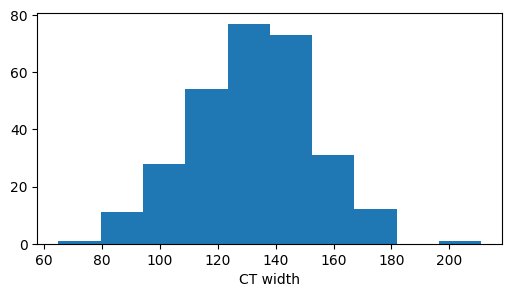

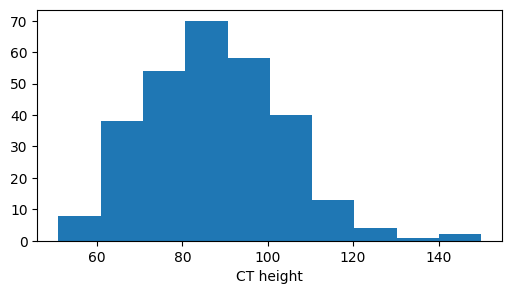

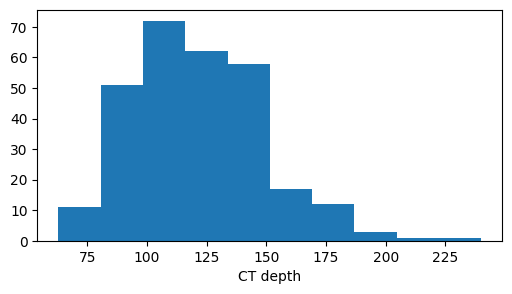

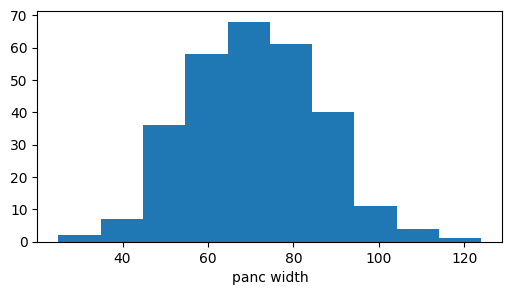

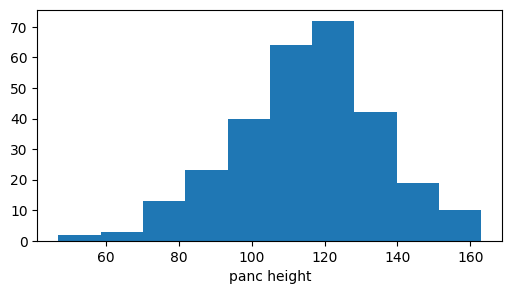

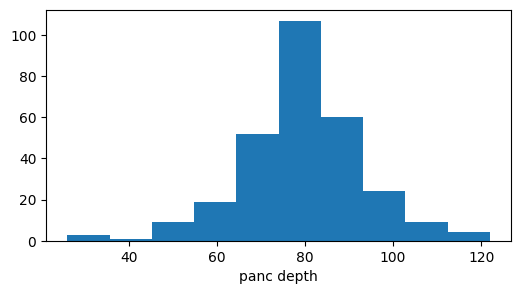

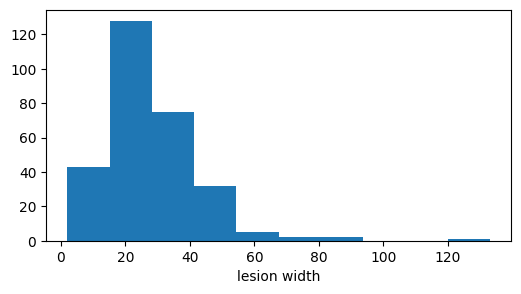

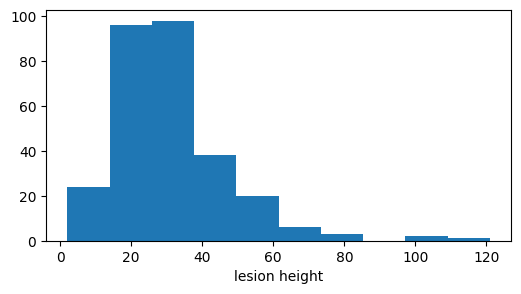

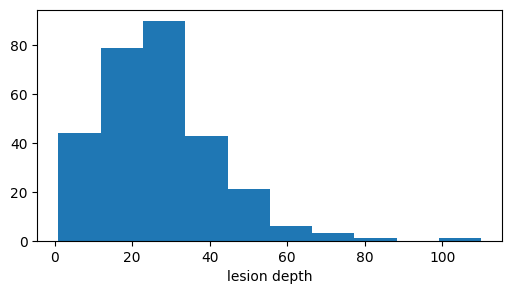

In [11]:
# load the metadata file
currentcsvpath = resampledcsvpath

trainval_df = pd.read_csv(currentcsvpath)

# check for duplicate IDs in train and val
IDs_dict = Counter(trainval_df['ID'])                 # generates a dictionary with the number of times each ID shows up
duplicate_IDs = {k:v for (k,v) in IDs_dict.items() if v > 1}     # generates a dictionary with any IDs that show up more than once

#print (duplicate_IDs)      
# gives me '{}' , so no duplicates in the data set which is great

# generates the quintiles of the CT/pancreas/lesion dimensions
for i, column in enumerate(trainval_df):
    quintile_str = column + ': '
    
    if (i > 2 and i <= 11):
        for i in range(5):
            quintile_str = quintile_str + ' ' + '%i'%(np.quantile(trainval_df[column].to_numpy(), (i / 4.)))
        print(quintile_str)
    elif i > 17 and i <= 20:
        for i in range(5):
            quintile_str = quintile_str + ' ' + '%3f'%(np.quantile(trainval_df[column].to_numpy(), (i / 5.)))
        print(quintile_str)

        
        
## generate histograms of metadata

for i, column in enumerate(trainval_df):
    if (i > 2 and i <= 11):
        plt.figure(i, figsize=(6, 3))
        plt.hist(trainval_df[column])
        plt.xlabel(column)


# Generate .npy files from nifti files

In [10]:
### Pre-processing the data 

# 1. Open the image and segmentation masks (projected onto the image) nifti files
# (currently without data augmentation)

if not os.path.isdir(numpydir):
    os.makedirs(numpydir)   
    

def getNumpysFromImageAndMask(imagepath, maskpath):
    """Input is file path of image and mask nifti files (panorama)
       Output is 1. image_npy: a 3D numpy of the CT scan
             2. mask_npy: 3D numpy of the mask, projected onto the image (nearest neighbor)
             """

    image = sitk.ReadImage(imagepath)
    mask = sitk.ReadImage(maskpath, sitk.sitkInt16)
    
    image = windowImage(image, window_width, window_center)
    #image = squareImage(image)
    
    projected_mask = projectImage(image, mask, interpolate = 'NN')

    image_npy = sitk.GetArrayFromImage(image)   #images are in z, y, x format
    mask_npy = sitk.GetArrayFromImage(projected_mask)
        
    return image_npy, mask_npy


### def augment(***)
                # 1. rotate 3D image
                #anglex = random.randint(0, 23) * 15  # rotate randomly, 15 degree increments from 0 to 345 degrees
                #angley = anglez = 0    #just rolling pin rotation

                #img = rotateImage(original, anglex, angley, anglez, 'linear')
                #seg = rotateImage(original, anglex, angley, anglez, 'nn')
                
                 # 3. make square and resample to 256 x 256***
                #img = squareImage(img)
                #img = resampleImage(img, 256)

                # 4. resample mask to final image
                #seg = projectImage(img, seg, interpolate='NN')
                
                # calculate bounding box of segmentation
                #segbbox = bbox_3D(seg)       #[xmin, xmax, ymin, ymax, zmin, zmax]
                #imgbbox = bbox_3D(img)

                
                
def niftis_to_numpys(df, trainorval, numpydir):
    
    for index, row in df.iterrows():
        imagepath = row['image path']
        maskpath = row['mask path']
        ID = int(row['ID'])
        subtype = row['subtype']
        
       
        # saves npy
        image_npy, mask_npy = getNumpysFromImageAndMask(imagepath, maskpath)
        
        image_filename =  os.path.join(numpydir, str(trainorval) + '_' + "{:03d}".format(ID) + '_image.npy')
        mask_filename = os.path.join(numpydir, str(trainorval) + '_' + "{:03d}".format(ID) + '_mask.npy')
        
        
        
        np.save(image_filename, image_npy)
        np.save(mask_filename, mask_npy)
        
    


In [11]:
# use resampled or original data?

if useResampledData:
    dfcsvpath = resampledcsvpath
else:
    dfcsvpath = csvpath

maindf = pd.read_csv(dfcsvpath)

print(dfcsvpath)

if firstrun:
    traindf = maindf.loc[maindf['train/val'] == 'train']
    valdf = maindf.loc[maindf['train/val'] == 'val']

    print('train')
    niftis_to_numpys(traindf, 'train', numpydir)
    
    print('val')
    niftis_to_numpys(valdf, 'val', numpydir)
    
    firstrun = False
    
print('done')

/kaggle/working/trainval_resampled_metadata.csv
train
val
done


In [12]:
def get_patch_minmax(dmin, dmax, image_dim, patch_dim):
    """
    Returns the possible min and max indices of the patch along dimension
    case 1 is if the pancreas is smaller than the patch
    case 2 is if the pancreas is bigger than the patch
    """
    if abs(dmax - dmin) <= patch_dim:
        #print('dmax - dmin < patch dim')
        patch_min = max(0, dmax - patch_dim)
        patch_max = min(dmin, image_dim - patch_dim)
    else:
        patch_min = dmin
        patch_max = dmax - patch_dim
    
    return patch_min, patch_max

def get_patches(image_npy, mask_npy, patch_width, patch_height, patch_depth, 
                topleft_row = 0, topleft_col = 0, topleft_depth = 0,
                pancreas_patch = False, lesion_patch = False, random = True):
    """ 
    Returns 3d patches of the 'image_npy' and segmentation 'mask_npy'
    with 'patch_depth' (depth), patch_width' (columns) and 'patch_height (rows)
    
    Can specify the top left corner: 'topleft_row' and 'topleft_col' and 'topleft_depth'
    
    Can specify if patch has to contain pancreas/lesion or not
    
    Can also return a random patch within the image/segmentation
    """
    
    image_depth, image_height, image_width = np.shape(image_npy)
    
    assert(patch_width < np.shape(image_npy)[2] and patch_height < np.shape(image_npy)[1] and patch_depth < np.shape(image_npy)[0])   ## CT image is z (slice index), y (row index), x (column index)
    
    if random:   # random patch, within constraints    
    # if it must contain the pancreas and lesion:
    # then you can only go up to panc min - patch size, and panc max + patch size
    # top left is going to be max(0, (panc min - patch size)) to min(image width, panc max + patch size)
    
        if lesion_patch:
            rmin, rmax, cmin, cmax, zmin, zmax = bbox_3D(mask_npy == 2)
            #print('lesion dims')
            
            #print('lesion patch')
        
            if rmin == -1 and pancreas_patch:
                rmin, rmax, cmin, cmax, zmin, zmax = bbox_3D(mask_npy == 1)
                #print('lesion_patch, but got pancreas patch')
            
        elif pancreas_patch:
            rmin, rmax, cmin, cmax, zmin, zmax = bbox_3D(mask_npy == 1)
            #print('pancreas patch')
            
        else:
            rmin, rmax, cmin, cmax, zmin, zmax = (-1, -1, -1, -1, -1, -1)
            #print('random patch')
            
        ### 2 cases:
        # case 1 is if the patch is bigger than the pancreas
        # then valid patches start from 0 to 
        
        # case 2 is if the pancreas is bigger than the patch
        # then valid patches start from panc_min to (panc_max - patch_size)
        
        #print('pancreas/lesion dims')
        #print(zmin, zmax, rmin, rmax, cmin, cmax)
        
        if rmin != -1:
            patch_zmin, patch_zmax = get_patch_minmax(zmin, zmax, image_depth, patch_depth)    
            patch_rmin, patch_rmax = get_patch_minmax(rmin, rmax, image_height, patch_height)    # y          
            patch_cmin, patch_cmax = get_patch_minmax(cmin, cmax, image_width, patch_width)      # x
            
            #print('depth z')
            #print(patch_zmin, patch_zmax)
            #print('rows y')
            #print(patch_rmin, patch_rmax)
            #print('columns x')
            #print(patch_cmin, patch_cmax)

            
        else:    # gets a random patch, as there is no pancreas or lesion
            patch_rmin = 0
            patch_rmax = image_height - patch_height
            patch_cmin = 0
            patch_cmax = image_width - patch_width
            patch_zmin = 0
            patch_zmax = image_depth - patch_depth
            #print('lesion/pancreas patch fail')
            
            #print('depth z')
            #print(patch_zmin, patch_zmax)
            #print('rows y')
            #print(patch_rmin, patch_rmax)
            #print('columns x')
            #print(patch_cmin, patch_cmax)
    
        if patch_zmin == patch_zmax:
            topleft_depth = patch_zmin
        else:
            topleft_depth = np.random.randint(patch_zmin, patch_zmax)    
        
        if patch_rmin == patch_rmax:
            topleft_row = patch_rmin
        else:
            topleft_row = np.random.randint(patch_rmin, patch_rmax)    # y
        
        if patch_cmin == patch_cmax:
            topleft_col == patch_cmin
        else:
            topleft_col = np.random.randint(patch_cmin, patch_cmax)    # x
        
        
    
    image_patch = image_npy[topleft_depth:(topleft_depth + patch_depth), topleft_row:(topleft_row + patch_height), topleft_col:(topleft_col + patch_width)]
    mask_patch = mask_npy[topleft_depth:(topleft_depth + patch_depth), topleft_row:(topleft_row + patch_height), topleft_col:(topleft_col + patch_width)]
    
    #print('top left z y x' + str((topleft_depth, topleft_row, topleft_col)))
    
    return image_patch, mask_patch, topleft_row, topleft_col, topleft_depth




(93, 74, 120)
(3, 48, 48, 48)


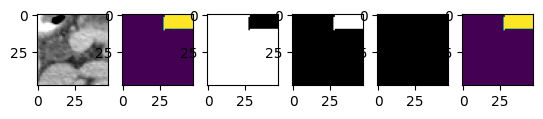

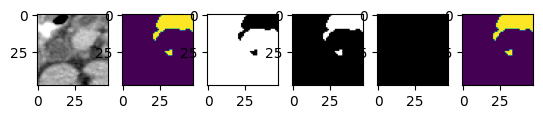

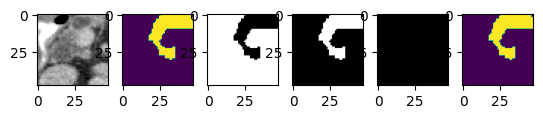

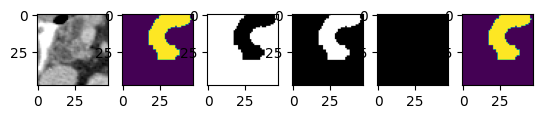

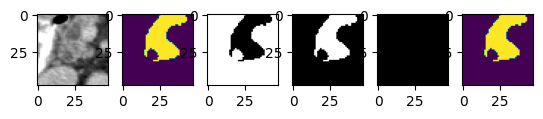

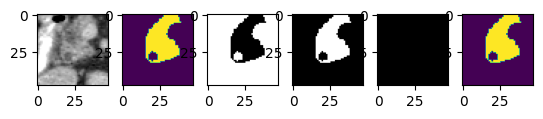

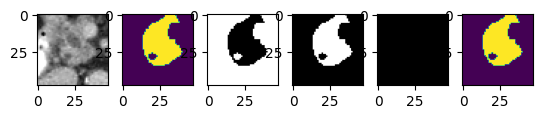

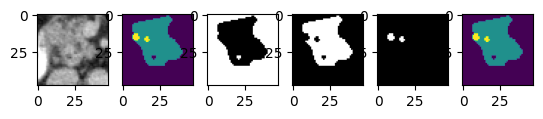

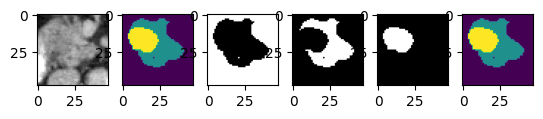

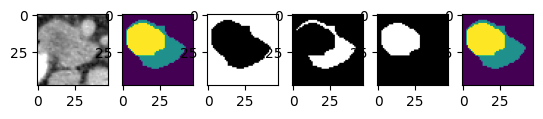

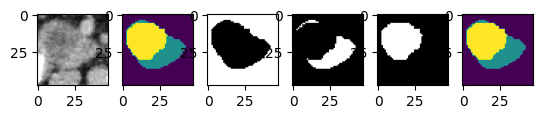

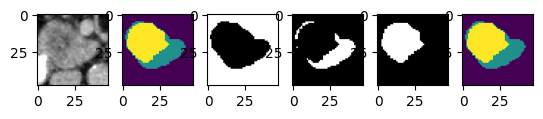

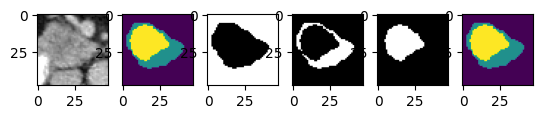

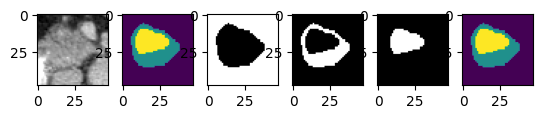

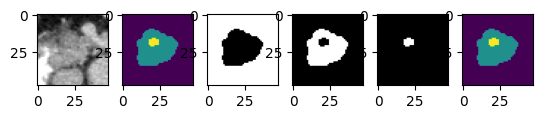

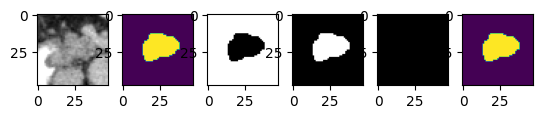

In [13]:
# checking to make sure get patches and one hot functions works

image_npy_path = '/kaggle/working/numpy/train_070_image.npy'
mask_npy_path = '/kaggle/working/numpy/train_070_mask.npy'

image_npy = np.load(image_npy_path)
mask_npy = np.load(mask_npy_path)

print(np.shape(mask_npy))

image_patch, mask_patch, topleft_r, topleft_c, topleft_d = get_patches(image_npy, mask_npy, 48, 48, 48, 0, 0, 0,
                                                                      pancreas_patch = False, lesion_patch = True, random = True)

one_hot_mask = one_hot_encode(mask_patch)

one_hot_mask_decode = one_hot_decode(one_hot_mask)

print(np.shape(one_hot_mask))

for zslice in range(np.shape(image_patch)[0]):
    if zslice % 3 == 0:
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
        ax1.imshow(image_patch[zslice, :, :], cmap='gray')
        ax2.imshow(mask_patch[zslice, :, :])
        ax3.imshow(one_hot_mask[0, zslice, :, :], cmap='gray')
        ax4.imshow(one_hot_mask[1, zslice, :, :], cmap='gray')
        ax5.imshow(one_hot_mask[2, zslice, :, :], cmap='gray')
        ax6.imshow(one_hot_mask_decode[zslice, :, :])


        

# Dataset class

In [13]:
class Dataset(data.Dataset):
    # dataset for segmentation task
    # has_pancreas is probability that patch contains pancreas
    # has_lesion is probability that patch contains lesion
    
    def __init__(self, trainvaldf, train=False, augment=False, shuffle=False, has_pancreas=0., has_lesion=0.):
        super().__init__()
        
        self.trainvaldf = trainvaldf
        
        #self.args = args
        self.train = train
        self.augment = augment
        self.shuffle = shuffle
        self.has_pancreas = has_pancreas
        self.has_lesion = has_lesion
        
        
    def __getitem__(self, index):
        row = self.trainvaldf.iloc[index]
        
        ID = row['ID']
        subtype = row['subtype']
        
        image_npy = row['image npy']
        mask_npy = row['mask npy']
        
        
        image = np.load(image_npy)
        mask = np.load(mask_npy)
        
        #print('ID: ' + str(ID) + '  slice num: ' + str(slicenum) + ' of image ' + str(np.shape(image)) + ' and mask ' + str(np.shape(mask)))
                        
        if self.train:     
            # get a random patch with probability that it has pancreas or lesion
            lesion_threshold = self.has_lesion
            panc_threshold = self.has_lesion + self.has_pancreas
            
            if random.random() < lesion_threshold:
                #print('lesion patch')
                lesion_patch = True
                pancreas_patch = False
            elif random.random() < panc_threshold:
                #print('pancreas patch')
                lesion_patch = False
                pancreas_patch = True
            else:
                #print('random patch')
                lesion_patch = False
                pancreas_patch = False
            
            image_patch, mask_patch, topleft_r, topleft_c, topleft_d = get_patches(image, mask, patch_width, patch_height, patch_depth, 0, 0, 0,
                                                                            pancreas_patch, lesion_patch, random = True)            
        else:
            # need to update this so we can specify a patch that's not the corner
            image_patch, mask_patch, topleft_r, topleft_c, topleft_d = get_patches(image, mask, patch_width, patch_height, patch_depth, 0, 0, 0,
                                                                            pancreas_patch=False, lesion_patch=False, random = True)
        
        image_patch = np.reshape(image_patch, (1, np.shape(image_patch)[0], np.shape(image_patch)[1], np.shape(image_patch)[2]))    # reshapes into 1 x row x col matrix for batch norm
        
        mask_patch_onehot = one_hot_encode(mask_patch)
        
        
        input_tensor = torch.FloatTensor(image_patch)
        label_tensor = torch.FloatTensor(mask_patch_onehot)
        
        return input_tensor, label_tensor, ID, subtype
    
    def __len__(self):
        return self.trainvaldf.shape[0]

# Training the model (segmentation)

In [14]:
def train_model(model, loader, gpu=False, optimizer=None):
    """ 
    runs one epoch of training (segmetnation)
    returns combination of generalized dice loss and cross entropy loss
    """
    model.train()
    
    total_loss = 0.
    num_batches = 0
    total_CE_loss = 0.
    total_GD_loss = 0.
    
    for i, batch in enumerate(loader):
        vol, label, ID, subtype = batch
        
        if gpu:
            vol = vol.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()           
        
        logit = model.forward(vol)
        
        CE_loss = cross_entropy_loss_fx(logit, label)        
        GD_loss = generalized_dice_loss(logit, label)
        
        
        loss = CE_loss + GD_alpha * GD_loss
        
        total_CE_loss += CE_loss.item()
        total_GD_loss += GD_loss.item()
        
        #print('train batch ' + str(i) + ' loss: ' + str(loss.item()))
        
        total_loss += loss.item()  #loss.item()
        
        loss.backward()
        optimizer.step()
        
        num_batches += 1
        

        del vol, label, logit, CE_loss, GD_loss
    
    avg_loss = total_loss / num_batches
    avg_GD_loss = total_GD_loss / num_batches
    avg_CE_loss = total_CE_loss / num_batches

    return avg_loss, avg_CE_loss, avg_GD_loss


def eval_model(model, loader, gpu=False, optimizer=None):
    """ 
    runs one epoch of validation set 
    returns generalized dice loss and/or cross entropy loss
    """
    model.eval()
    
    total_loss = 0.
    num_batches = 0
    total_CE_loss = 0.
    total_GD_loss = 0.
    
    for i, batch in enumerate(loader):
        with torch.no_grad():
            vol, label, ID, subtype = batch
        
            if gpu:
                vol = vol.cuda()
                label = label.cuda()
        
            logit = model.forward(vol)
        
            CE_loss = cross_entropy_loss_fx(logit, label)        
            GD_loss = generalized_dice_loss(logit, label)
        
            #### WHICH LOSS? ####
            loss = CE_loss + GD_alpha * GD_loss
            
            total_CE_loss += CE_loss.item()
            total_GD_loss += GD_loss.item()
            
           
            #print('val batch ' + str(i) + ' loss: ' + str(loss.item()))
        
            total_loss += loss.item()  #loss.item()
        
            num_batches += 1
        
        del vol, label, logit, loss, CE_loss, GD_loss
    
    avg_loss = total_loss / num_batches
    avg_GD_loss = total_GD_loss / num_batches
    avg_CE_loss = total_CE_loss / num_batches

    return avg_loss, avg_CE_loss, avg_GD_loss


In [ ]:
#########################
### Training the model
#########################

### To do:
### 1. implement hyperparameter search (learning rate alpha, momentum beta, dropout, weight decay) -- weights and biases?

In [15]:
# continue training?
continue_training = True
last_model_path = '/kaggle/input/3d-pancreas-sept-17-epoch-200/pytorch/default/1/epoch200_train0.1730_val0.1258_Sept17.pth'

# force patches to have pancreas or lesion?
has_pancreas = 0.4
has_lesion = 0.4

    

In [ ]:
outdf = pd.DataFrame({'epoch': pd.Series(dtype='string'),
               'train_loss': pd.Series(dtype='string'),
               'val_loss': pd.Series(dtype='string'),
               'train_CE_loss': pd.Series(dtype='string'),
               'train_GD_loss': pd.Series(dtype='string'),
               'val_CE_loss': pd.Series(dtype='string'),
               'val_GD_loss': pd.Series(dtype='string')
              })

trainingcurvecsvpath = os.path.join(modeldir, 'trainingcurve.csv')

dropout = 0.25 #dropout probability
learning_rate = 1e-5
weight_decay = 1e-4
momentum = .9    # beta, exponentially weighted average
epochs = 200

GD_alpha = 0

batch_size = 16
num_workers = 0


model = UNet(model_depth = model_depth, num_channels = 1, num_classes = 3, init_method='xavier')

if gpu:
    model = model.cuda()

if continue_training:
    model.load_state_dict(torch.load(last_model_path))
    last_model_finalepoch = ((last_model_path.split('/')[-1]).split('_')[0]).split('epoch', 1)[1]
    #outdf = pd.read_csv(trainingcurvecsvpath)

else:
    last_model_finalepoch = 0
    
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=.3, threshold=1e-4)

cross_entropy_loss_fx = nn.CrossEntropyLoss()


train_dataset = Dataset(traindf, train=True, augment=False, shuffle=True, has_pancreas=has_pancreas, has_lesion=has_lesion)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = Dataset(valdf, train=False, augment=False, shuffle=False, has_pancreas=has_pancreas, has_lesion=has_lesion)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
print('Done loading data!')    


start_time = datetime.now()


for epoch in range(epochs):
    change = datetime.now() - start_time
    currentepoch = int(last_model_finalepoch) + epoch + 1
    
    print('starting epoch {}. last LR: {}. time passed: {}'.format(currentepoch, str(scheduler.get_last_lr()), str(change)))
        
    train_loss, train_CE_loss, train_GD_loss = train_model(model, train_loader, gpu=gpu, optimizer=optimizer)
    print(f' train loss: {train_loss:0.4f}' + f' CE loss: {train_CE_loss:0.4f}' + f' GD loss: {train_GD_loss:0.4f}')    
    
    val_loss, val_CE_loss, val_GD_loss = eval_model(model, val_loader, gpu=gpu)
    print(f' val loss: {val_loss:0.4f}' + f' CE loss: {val_CE_loss:0.4f}' + f' GD loss: {val_GD_loss:0.4f}')
    
    scheduler.step(train_loss)

    #save the model for every n epochs
    if currentepoch % 10 == 0:    
        file_name = f'epoch{currentepoch}_train{train_loss:0.4f}_val{val_loss:0.4f}' + '.pth'
        save_path = os.path.join(modeldir, file_name)

        torch.save(model.state_dict(), save_path)
        
        print('saved model ' + save_path)

    
    outdata = pd.DataFrame({'epoch':currentepoch, 'train_loss':train_loss, 'val_loss':val_loss, 
                            'train_CE_loss':train_CE_loss, 'train_GD_loss':train_GD_loss,
                            'val_CE_loss': val_CE_loss, 'val_GD_loss': val_GD_loss}, index=[0])
    
    if currentepoch == 1:
        outdf = outdata
    else:
        outdf = pd.concat([outdf, outdata]) 
    
    outdf.to_csv(trainingcurvecsvpath, index=False)

print('training done!')

In [ ]:
#outdf.to_csv(trainingcurvecsvpath, index=False)

In [ ]:
#graph training curve

trainingcurve_df = pd.read_csv(os.path.join(modeldir, 'trainingcurve.csv'))

print(trainingcurve_df)
plt.figure()
plt.plot(trainingcurve_df['epoch'], trainingcurve_df['train_loss'], label='train')
plt.plot(trainingcurve_df['epoch'], trainingcurve_df['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure()
plt.plot(trainingcurve_df['epoch'], trainingcurve_df['train_GD_loss'], label='train gen. dice')
plt.plot(trainingcurve_df['epoch'], trainingcurve_df['val_GD_loss'], label='val gen. dice')
plt.legend()
plt.show()

plt.figure()
plt.plot(trainingcurve_df['epoch'], trainingcurve_df['train_CE_loss'], label='train cross entropy')
plt.plot(trainingcurve_df['epoch'], trainingcurve_df['val_CE_loss'], label='val cross entropy')
plt.legend()
plt.show()

In [ ]:
# to do Aug 31: 

### Evaluation
#val_loss = run_model(model, val_loader, gpu=gpu, train=False)
#print(f'valid loss: {val_loss:0.4f}')

# Accuracy of data set


#model_path = '/kaggle/working/models/epoch380_train0.4688_val0.5555'

#model = UNet(model_depth = model_depth, num_channels = 1, num_classes = 3, init_method='xavier')

#if gpu:
#    model = model.cuda()
    
#model.load_state_dict(torch.load(model_path))

In [16]:
# load a model
batch_size = 16
num_workers = 0

last_model_path = '/kaggle/input/3d-panc-epoch-250/pytorch/default/1/epoch250_train0.1616_val0.1308.pth'

model = UNet(model_depth = model_depth, num_channels = 1, num_classes = 3, init_method='xavier')


if gpu:
    model = model.cuda()
    
model.load_state_dict(torch.load(last_model_path, map_location=torch.device('cpu')))





/tmp/ipykernel_36/2813873359.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(last_model_path, map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
train_dataset = Dataset(traindf, train=True, augment=False, shuffle=True, has_pancreas=has_pancreas, has_lesion=has_lesion)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = Dataset(valdf, train=False, augment=False, shuffle=False, has_pancreas=has_pancreas, has_lesion=has_lesion)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


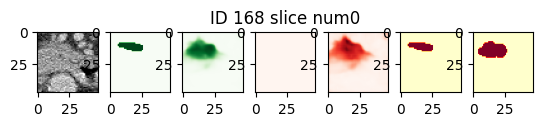

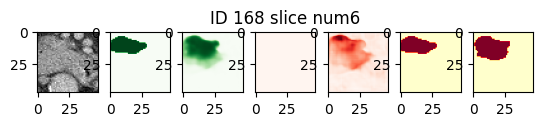

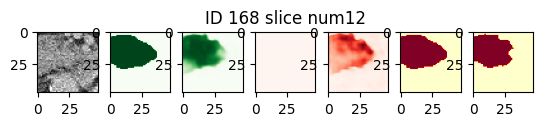

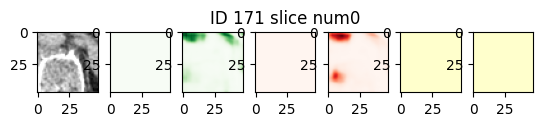

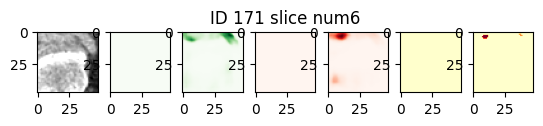

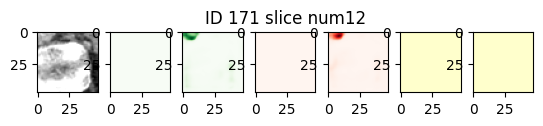

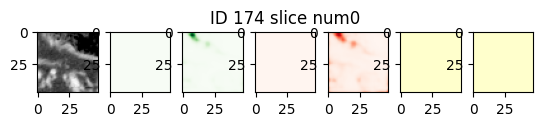

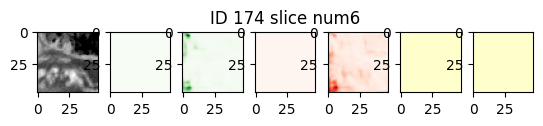

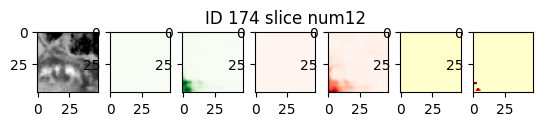

In [20]:
# visualize the output 

# training set or validation set?
loader = val_loader

with torch.no_grad():
    for i, batch in enumerate(loader):
        if i <= 0:
            vol, label, ID, subtype = batch
            
            ID = ID.detach().cpu().numpy()
            
            if gpu:
                vol = vol.cuda()
                label = label.cuda()
        
            logit = model.forward(vol)
            probs = F.softmax(logit, dim=1)
            batch_size = probs.size(0)
            
            prediction = torch.argmax(probs, dim=1)           # takes the maximum probability
            
            probs_npy = probs.detach().cpu().numpy()            
            prediction_npy = prediction.detach().cpu().numpy()
            
            image_npy = vol.detach().cpu().numpy()
            mask_npy = label.detach().cpu().numpy()
            
            
            for batch_i in range(np.shape(prediction_npy)[0]):
                if batch_i <= 2:
                    for zslice in range(np.shape(image_npy)[0]):
                        if zslice % 6 == 0:
                            fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7)

                            mask_slice = one_hot_decode(mask_npy[batch_i, :, zslice])
                            
                            #print(np.shape(mask_one_hot))
                            #print(np.unique(mask_one_hot))
                            #fig.set_figheight(2)
                            #fig.set_figwidth(10)
                            ax4.set_title('ID ' + str(ID[batch_i]) + ' slice num' + str(zslice))
            
                            ax1.imshow(image_npy[batch_i, 0, zslice, :, :], cmap='gray')    # CT image
                            ax2.imshow(mask_npy[batch_i, 1, zslice, :, :], cmap='Greens')     # pancreas ground truth
                            ax3.imshow(probs_npy[batch_i, 1, zslice, :, :], cmap='Greens')    # pancreas probability
                                
                            ax4.imshow(mask_npy[batch_i, 2, zslice, :, :], cmap='Reds')    # lesion ground truth
                            ax5.imshow(probs_npy[batch_i, 2, zslice, :, :], cmap='Reds')    # lesion probability
                            
                            ax6.imshow(mask_slice, cmap = 'YlOrRd')                            # mask ground truth
                            ax7.imshow(prediction_npy[batch_i, zslice, :, :], cmap = 'YlOrRd')              # predicted mask

                            #plt.close(fig)
                            #ax1.imshow(image_slice, cmap='gray')
                            #ax2.imshow(mask_slice * (mask_slice == 1), cmap='hot')
                            #ax3.imshow(predicted_mask_slice * (predicted_mask_slice == 1), cmap='hot')
                            #ax4.imshow(mask_slice * (mask_slice == 2), cmap = 'Reds')
                            #ax5.imshow(predicted_mask_slice * (predicted_mask_slice == 2), cmap = 'Reds')

In [ ]:
# delete models?
#import glob

#files = glob.glob(modeldir + '/*')

#for f in files:
#    os.remove(f)
    

# Segmentation Inference

In [17]:
def get_patch_coordinates(npy, patch_size):
    ''' returns coordinates (top left corner) of patches to span the entire segmentation mask
    '''
    npy_size = np.shape(npy)
    patch_size = np.array(patch_size)
    
    num_patches = np.floor(np.divide(np.shape(npy), patch_size)) + 1
    
    pixel_spacing = (npy_size - patch_size)/(num_patches - 1)

    z_coordinates = np.floor(pixel_spacing[0] * np.arange(0, num_patches[0]))
    y_coordinates = np.floor(pixel_spacing[1] * np.arange(0, num_patches[1]))
    x_coordinates = np.floor(pixel_spacing[2] * np.arange(0, num_patches[2]))
    
    z_coordinates = z_coordinates.astype(np.int32)
    y_coordinates = y_coordinates.astype(np.int32)
    x_coordinates = x_coordinates.astype(np.int32)
    
    return z_coordinates, y_coordinates, x_coordinates
    

def get_patch_with_coordinates(npy, z, y, x, patch_size):
    '''  returns patch given top left coordinates and patch size
    '''
    return npy[z:(z+patch_size), y:(y+patch_size), x:(x+patch_size)]


def get_dice_score(x, y, label):
    ''' 
    returns dice score for *label* (1 = pancreas, 2 = lesion)    
    
    formula = 2 * (intersection) / (x + y)
    '''
    x = x[label]
    y = y[label]
    
    return (2*np.sum(x*y)/ np.sum(x + y))


def get_predicted_segmentation(image_npy, patch_size = 48):
    '''
    returns the full predicted segmentation by adding the patches together
    '''
    with torch.no_grad():
        # calculate the coordinates (top left corner) of the patches (z, y, x)
        z_coordinates, y_coordinates, x_coordinates = get_patch_coordinates(image_npy, patch_size)

        # initializes 3D array of predicted segmentation probabilities
        mask_size = np.shape(image_npy)
        one_hot_mask_size = np.append(3, mask_size)     # (one hot, z, y ,x)

        predicted_mask_probs = np.zeros(one_hot_mask_size)
        counter_one_hot = np.zeros(one_hot_mask_size)

        # loop over all patches
        for z in z_coordinates:
            for y in y_coordinates:
                for x in x_coordinates:
                    # get the image patch corresponding to the coordinates (top left corner)
                    image_patch = get_patch_with_coordinates(image_npy, z, y, x, patch_size)
                    image_patch = np.reshape(image_patch, (1, 1, np.shape(image_patch)[0], np.shape(image_patch)[1], np.shape(image_patch)[2]))    # reshapes into 1 x row x col matrix for batch norm

                    image_patch_tensor = torch.FloatTensor(image_patch)

                    if gpu:
                        image_patch_tensor = image_patch_tensor.cuda()

                    # feed into model
                    predicted_mask_patch_tensor = model.forward(image_patch_tensor)
                    predicted_mask_patch_npy = np.squeeze(predicted_mask_patch_tensor.detach().cpu().numpy())

                    # sew the patch to the quilt of predicted segmentation probabilities
                    predicted_mask_probs[:, z:(z+patch_size), y:(y+patch_size), x:(x+patch_size)] += predicted_mask_patch_npy
                    counter_one_hot[:, z:(z+patch_size), y:(y+patch_size), x:(x+patch_size)] += 1


        predicted_mask_probs = predicted_mask_probs/counter_one_hot
                
    return predicted_mask_probs

In [18]:
print(valdf)

      ID train/val  subtype  CT width  CT height  CT depth  panc width  \
252  168       val        0       121         98       146          89   
253  171       val        0       125        108       102          91   
254  174       val        0        86         58       215          45   
255  184       val        0       130         78       150          59   
256  187       val        0       135        120        98         105   
257  189       val        0        88         62        93          48   
258  244       val        0       156         75        99          66   
259  253       val        0       150         90        99          74   
260  254       val        0       118        118       119         103   
261   90       val        1       144         78       156          61   
262   93       val        1       152         73       110          56   
263   94       val        1       140         83        94          68   
264  154       val        1       131 

In [19]:
predictedmaskdir = '/kaggle/working/predicted_masks/'

if os.path.exists(predictedmaskdir) == False:
    os.makedirs(predictedmaskdir)
    

patch_size = 48
model.eval()


start_time = datetime.now()

        

#image_npy_path = '/kaggle/working/numpy/val_191_image.npy'
#mask_npy_path = '/kaggle/working/numpy/val_191_mask.npy'

# inference over validation set

for i, row in valdf.iterrows():
    if 255 == 255:
        train_or_val = row['train/val']
        ID = row['ID']
        subtype = row['subtype']
        
        change = datetime.now() - start_time
        
        print('starting  {} ID {} subtype {}. time passed: {}'.format(train_or_val, ID, subtype, str(change)))

        resampled_image_nii_path = row['image path']
        resampled_mask_nii_path = row['mask path']

        original_image_nii_path = row['original image path']
        original_mask_nii_path = row['original mask path']

        print(resampled_mask_nii_path)

        # load the images -- the resampled (1x1x1 mm voxel) images and the original ones
        resampled_image_nii = sitk.ReadImage(resampled_image_nii_path)
        resampled_mask_nii = sitk.ReadImage(resampled_mask_nii_path, sitk.sitkInt16)

        original_image_nii = sitk.ReadImage(original_image_nii_path)
        original_mask_nii = sitk.ReadImage(original_mask_nii_path, sitk.sitkInt16)


        # window the image fed into the model
        resampled_image_nii = windowImage(resampled_image_nii, window_width, window_center, output_min = 0, output_max = 255)


        # get the numpy arrays from the images
        resampled_image_npy = sitk.GetArrayFromImage(resampled_image_nii)
        resampled_mask_npy = sitk.GetArrayFromImage(resampled_mask_nii)

        original_image_npy = sitk.GetArrayFromImage(original_image_nii)
        original_mask_npy = sitk.GetArrayFromImage(original_mask_nii)

        resampled_one_hot_mask = one_hot_encode(resampled_mask_npy)
        original_one_hot_mask = one_hot_encode(original_mask_npy)

        # generate the predicted segmentation, using the resampled image
        predicted_mask_probs = get_predicted_segmentation(resampled_image_npy, patch_size)

        predicted_mask = one_hot_decode(predicted_mask_probs)
        predicted_mask_one_hot = one_hot_encode(predicted_mask)

        # project the predicted segmentation onto the original image
        resampled_predicted_mask_nii = sitk.GetImageFromArray(predicted_mask)
        resampled_predicted_mask_nii.CopyInformation(resampled_mask_nii)

        original_predicted_mask_nii = projectImage(original_mask_nii, resampled_predicted_mask_nii, interpolate='NN')
        original_predicted_mask_npy = sitk.GetArrayFromImage(original_predicted_mask_nii)

        original_predicted_mask_one_hot = one_hot_encode(original_predicted_mask_npy)


        # calculate the dice score for both the resampled and the original iamges
        ### dice (resampled)
        resampled_pancreas_dice = get_dice_score(resampled_one_hot_mask, predicted_mask_one_hot, 1)
        resampled_lesion_dice = get_dice_score(resampled_one_hot_mask, predicted_mask_one_hot, 2)

        ### dice (original mask)
        original_pancreas_dice = get_dice_score(original_one_hot_mask, original_predicted_mask_one_hot, 1)
        original_lesion_dice = get_dice_score(original_one_hot_mask, original_predicted_mask_one_hot, 2)

        print(f'original pancreas dice: {original_pancreas_dice:0.3f}' +  f' lesion dice: {original_lesion_dice:0.3f}')
        
        # save the segmentation output (on resampled and original)

        ### get the stem of the file name
        image_name = (resampled_mask_nii_path.split('/')[-1]).split('.')[0]
        ##### example: '/kaggle/working/resampled/validation/subtype2/quiz_2_191.nii'
        ##### print(image_name)

        resampled_predicted_mask_nii_filename = image_name + '_pred_resampled.nii'
        original_predicted_mask_nii_filename = image_name + '_pred_original.nii'


        ### save the files
        resampled_predicted_mask_nii_path = os.path.join(predictedmaskdir, resampled_predicted_mask_nii_filename)
        original_predicted_mask_nii_path = os.path.join(predictedmaskdir, original_predicted_mask_nii_filename)

        sitk.WriteImage(resampled_predicted_mask_nii, resampled_predicted_mask_nii_path, useCompression=True)
        sitk.WriteImage(original_predicted_mask_nii, original_predicted_mask_nii_path, useCompression=True)

        print('resampled prediction written: ' + resampled_predicted_mask_nii_path)
        print('original prediction written: ' + original_predicted_mask_nii_path)

        # update the dataframe with metadata
        valdf.loc[i, 'original dice pancreas'] = original_pancreas_dice
        valdf.loc[i, 'original dice lesion'] = original_lesion_dice

        valdf.loc[i, 'resampled dice pancreas'] = resampled_pancreas_dice
        valdf.loc[i, 'resampled dice lesion'] = resampled_lesion_dice

        valdf.loc[i, 'resampled predicted mask path'] = resampled_predicted_mask_nii_path
        valdf.loc[i, 'original predicted mask path'] = original_predicted_mask_nii_path


prediction_file_name = '/kaggle/working/trainval_resampled_withpreds.csv'
valdf.to_csv(prediction_file_name)

starting  val ID 168 subtype 0. time passed: 0:00:00.001488
/kaggle/working/resampled/validation/subtype0/quiz_0_168.nii
original pancreas dice: 0.610 lesion dice: 0.041
resampled prediction written: /kaggle/working/predicted_masks/quiz_0_168_pred_resampled.nii
original prediction written: /kaggle/working/predicted_masks/quiz_0_168_pred_original.nii
starting  val ID 171 subtype 0. time passed: 0:01:07.849426
/kaggle/working/resampled/validation/subtype0/quiz_0_171.nii


/tmp/ipykernel_36/2279241251.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valdf.loc[i, 'original dice pancreas'] = original_pancreas_dice
/tmp/ipykernel_36/2279241251.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valdf.loc[i, 'original dice lesion'] = original_lesion_dice
/tmp/ipykernel_36/2279241251.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

original pancreas dice: 0.730 lesion dice: 0.000
resampled prediction written: /kaggle/working/predicted_masks/quiz_0_171_pred_resampled.nii
original prediction written: /kaggle/working/predicted_masks/quiz_0_171_pred_original.nii
starting  val ID 174 subtype 0. time passed: 0:01:55.764298
/kaggle/working/resampled/validation/subtype0/quiz_0_174.nii
original pancreas dice: 0.698 lesion dice: 0.014
resampled prediction written: /kaggle/working/predicted_masks/quiz_0_174_pred_resampled.nii
original prediction written: /kaggle/working/predicted_masks/quiz_0_174_pred_original.nii
starting  val ID 184 subtype 0. time passed: 0:02:34.538941
/kaggle/working/resampled/validation/subtype0/quiz_0_184.nii
original pancreas dice: 0.726 lesion dice: 0.676
resampled prediction written: /kaggle/working/predicted_masks/quiz_0_184_pred_resampled.nii
original prediction written: /kaggle/working/predicted_masks/quiz_0_184_pred_original.nii
starting  val ID 187 subtype 0. time passed: 0:03:19.856608
/kagg

In [30]:
print(resampled_predicted_mask_nii_path)
print(original_predicted_mask_nii_path)

print(predictedmaskdir)

print(resampled_mask_nii_path)

image_name = (resampled_mask_nii_path.split('/')[-1]).split('.')[0]
print(image_name)


/kaggle/working/resampled/validation/subtype0/quiz_0_171_pred_resampled.nii
/kaggle/working/resampled/validation/subtype0/quiz_0_171_pred_original.nii
/kaggle/working/predicted_masks/
/kaggle/working/resampled/validation/subtype0/quiz_0_171.nii
quiz_0_171


In [22]:

for i, row in valdf.iterrows():
    print(i)

252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287


(3, 87, 124, 179)
(3, 87, 124, 179)
[0 1 2]
[0 1 2]
0.5440797324116953
0.07850382027597218
0.5394754419557376
0.07746811525743977


In [22]:
print(resampleddf)

     ID train/val subtype  CT width  CT height  CT depth  panc width  \
0    41     train       0       114         82        85          67   
0    60     train       0       137         75       135          54   
0    66     train       0       123         82        95          67   
0    70     train       0       120         74        93          58   
0    77     train       0       111         84       138          59   
..  ...       ...     ...       ...        ...       ...         ...   
0   191       val       2       161        111       130          92   
0   241       val       2       159        104        93          86   
0   364       val       2        95         57       120          41   
0   377       val       2       138        127       118          89   
0   379       val       2       147         91       106          72   

    panc height  panc depth  lesion width  ...  CT spacing x  CT spacing y  \
0            99          68            24  ...           

In [38]:

resampled_mask_nii_path = os.path.join(predictedmaskdir, 'quiz_2_191_pred_resampled.nii')
original_mask_nii_path = os.path.join(predictedmaskdir, 'quiz_2_191_pred_original.nii')

sitk.WriteImage(resampled_predicted_mask_nii, resampled_mask_nii_path, useCompression=True)
sitk.WriteImage(original_predicted_mask_nii, original_mask_nii_path, useCompression=True)

In [ ]:
# statistics for the dice scores

In [59]:
mask_nii = sitk.ReadImage(mask_nii_path)
mask_nii_original = sitk.ReadImage()






# Converting back to SimpleITK (assumes we didn't move the image in space as we copy the information from the original)
result_image = sitk.GetImageFromArray(npa_res)
result_image.CopyInformation(inputImage)

# write the image
sitk.WriteImage(result_image, '/path/to/result.nii.gz')

In [49]:
predicted_mask_probs = get_predicted_segmentation(image_npy, patch_size)
predicted_mask_one_hot = predicted_mask_probs

one_hot_mask = one_hot_encode(mask_npy)

predicted_mask = one_hot_decode(predicted_mask_one_hot)
predicted_mask_one_hot = one_hot_encode(predicted_mask)

print(np.shape(one_hot_mask[1]))
print(np.shape(predicted_mask))
print(np.shape(predicted_mask_one_hot))

x = one_hot_mask[1]
y = predicted_mask_one_hot[1]

print((np.sum(x*y)))
print((np.sum(x+y)))
pancreas_dice = get_dice_score(one_hot_mask, predicted_mask_one_hot, 1)
print(pancreas_dice)

lesion_dice = get_dice_score(one_hot_mask, predicted_mask_one_hot, 2)
print(lesion_dice)

(93, 74, 120)
(93, 74, 120)
(3, 93, 74, 120)
37208
86745
(93, 74, 120)
(93, 74, 120)
0.8578707706496052
(93, 74, 120)
(93, 74, 120)
0.8364585229686268


/tmp/ipykernel_36/3696836636.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7)


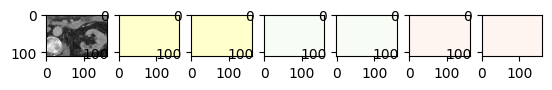

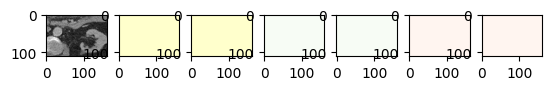

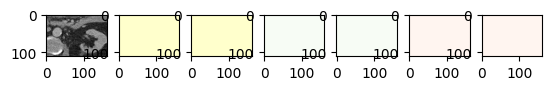

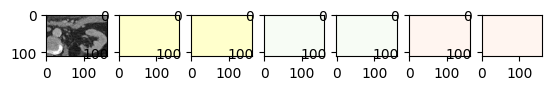

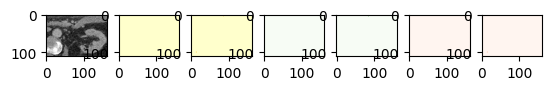

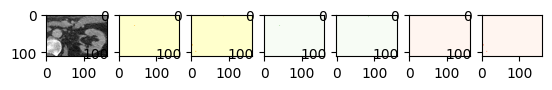

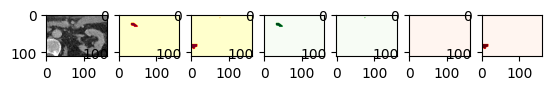

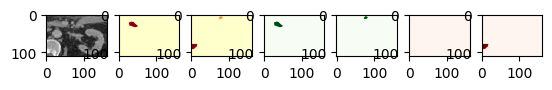

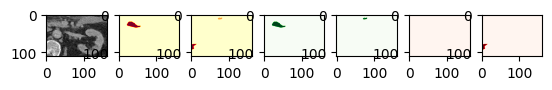

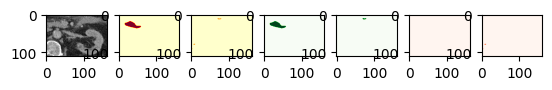

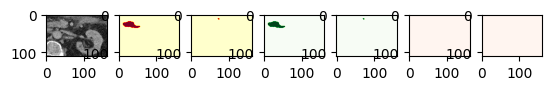

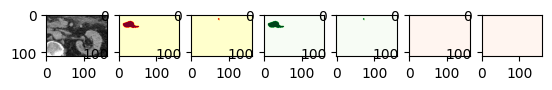

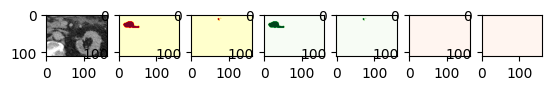

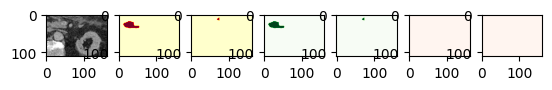

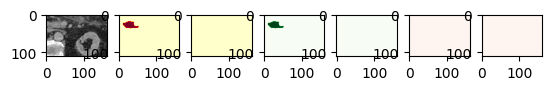

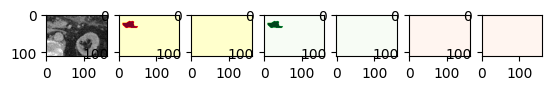

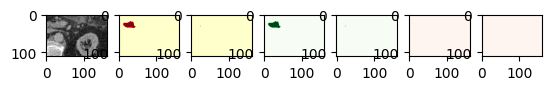

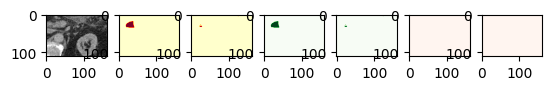

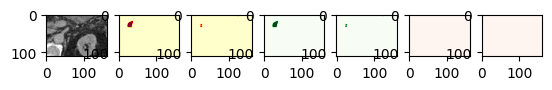

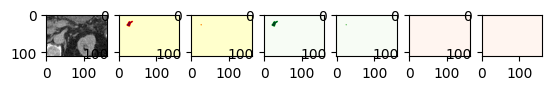

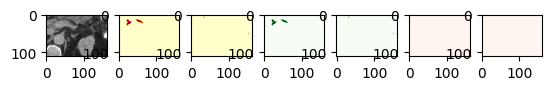

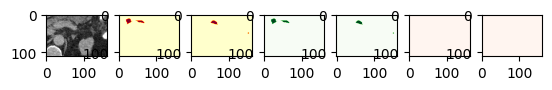

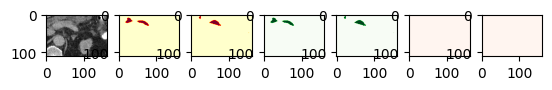

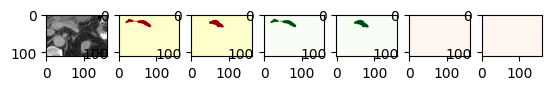

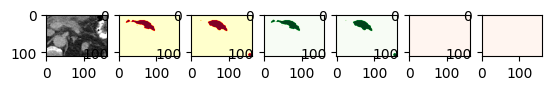

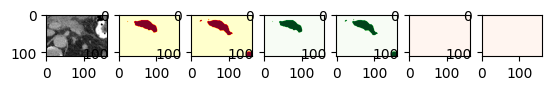

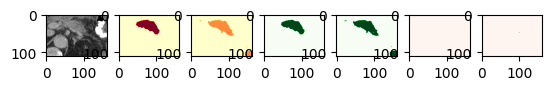

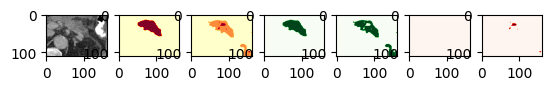

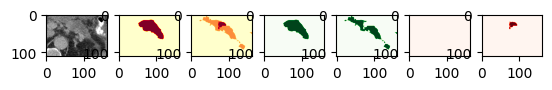

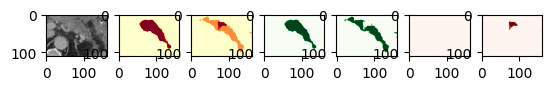

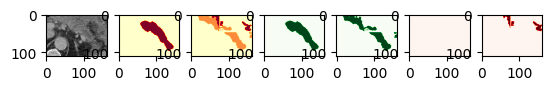

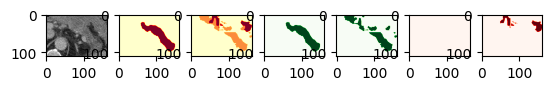

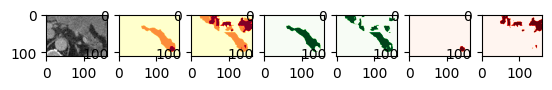

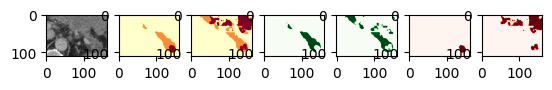

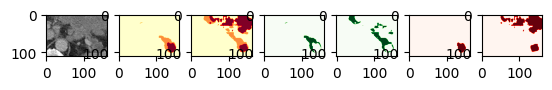

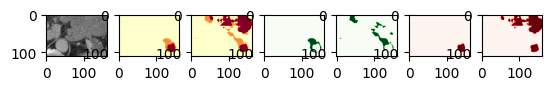

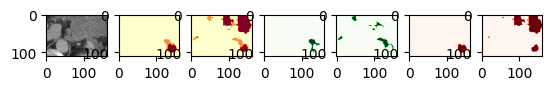

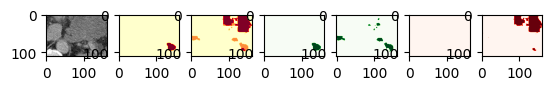

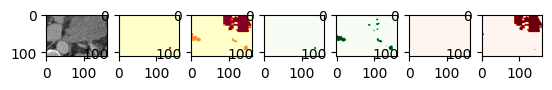

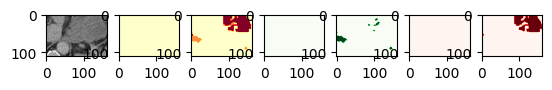

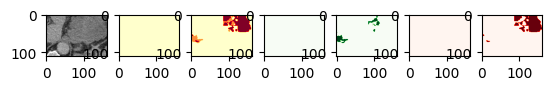

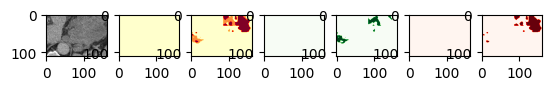

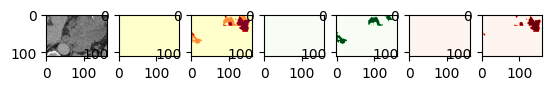

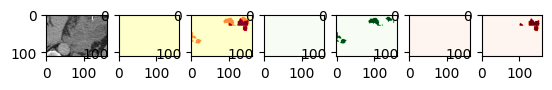

In [58]:


for zslice in range(np.shape(image_npy)[0]):
    if zslice % 3 == 0:
        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7)
        ax1.imshow(image_npy[zslice, :, :], cmap='gray')    # CT image
        
        ax2.imshow(mask_npy[zslice, :, :], cmap = 'YlOrRd')                            # mask ground truth
        ax3.imshow(predicted_mask[zslice, :, :], cmap = 'YlOrRd')              # predicted mask
        
        ax4.imshow(one_hot_mask[1, zslice, :, :], cmap='Greens')     # pancreas ground truth
        ax5.imshow(predicted_mask_one_hot[1, zslice, :, :], cmap='Greens')    # pancreas probability

        ax6.imshow(one_hot_mask[2, zslice, :, :], cmap='Reds')    # lesion ground truth
        ax7.imshow(predicted_mask_one_hot[2, zslice, :, :], cmap='Reds')    # lesion probability

        
#logit = model.forward(vol)


    # 3. get the predicted segmentation masks and combine them


    # 4. combine the predicted segmentation masks




    # 3. create a mesh of the coordinates for the boxes 
    # for each dimension, number of patches is going to be (width - patch size)/patchsize + 1


# Training the model (classification)

At this point, the segmentation model weights and biases are frozen. 

The Unet_classify_head is then trained. The encoder half is frozen, and only the fully connected parameters are updated. 

In [ ]:
### Caculates the Dice score on the validation set
### (per patient/CT scan)

In [ ]:
##############################
##############################
### DEBUGGING CODE BELOW
##############################
##############################

In [ ]:
##############################
##############################
### DEBUGGING CODE BELOW
##############################
##############################

# Testing/Debugging Functions

# Statistics

In [ ]:
##############################
##############################
### OLD CODE BELOW
##############################
##############################

# (Old code below)